In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input, Conv2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_dataset():
    # Base directories
    train_dir = "/kaggle/input/thermal-images-for-breast-cancer-diagnosis-dmrir/Imagens e Matrizes da Tese de Thiago Alves Elias da Silva/Desenvolvimento da Metodologia"
    
    # Find the DOENTES and SAUDÁVEIS directories
    train_folders = os.listdir(train_dir)
    doentes_dir = os.path.join(train_dir, [folder for folder in train_folders if "DOENTES" in folder][0])
    saudaveis_dir = os.path.join(train_dir, [folder for folder in train_folders if "SAUD" in folder][0])
    
    # Function to load images from the "Segmentadas" subdirectories
    def load_images_from_segmentadas(directory, label):
        images = []
        labels = []
        
        for root, dirs, files in os.walk(directory):
            # Only process files inside "Segmentadas" subdirectories
            if "Segmentadas" in root:
                for file_name in files:
                    file_path = os.path.join(root, file_name)
                    
                    # Skip non-image files
                    if not file_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                        continue
                    
                    # Preprocess the image
                    img = preprocess_image(file_path)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
        
        return images, labels
    
    # Load images from both directories
    print("Loading cancer (DOENTES) images...")
    cancer_images, cancer_labels = load_images_from_segmentadas(doentes_dir, 1)
    
    print("Loading healthy (SAUDÁVEIS) images...")
    healthy_images, healthy_labels = load_images_from_segmentadas(saudaveis_dir, 0)
    
    # Combine datasets
    all_images = cancer_images + healthy_images
    all_labels = cancer_labels + healthy_labels
    
    # Convert to numpy arrays
    X = np.array(all_images)
    y = np.array(all_labels)
    
    # Print the shape before conversion
    print(f"Dataset shape before RGB conversion: {X.shape}")
    
    # Convert grayscale to RGB (duplicate channels)
    if X.ndim == 3:  # If shape is (n, 224, 224)
        X = np.stack([X, X, X], axis=-1)
    
    # Print the shape after conversion
    print(f"Dataset shape after RGB conversion: {X.shape}")
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    return X_train, X_test, y_train, y_test


In [3]:
# Function to preprocess images
def preprocess_image(img_path):
    # Read image in grayscale mode
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Noise reduction using median filtering
    img = cv2.medianBlur(img, 3)
    
    # Resize to 224x224 (standard for CNNs)
    img = cv2.resize(img, (224, 224))
    
    # Normalize pixel values to [0, 1]
    img = img.astype('float32') / 255.0

    return img

In [16]:
import keras.backend as K
from sklearn.metrics import cohen_kappa_score
from keras.metrics import AUC
from keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.applications import VGG19

# Custom Cohen's Kappa metric
def cohen_kappa(y_true, y_pred):
    y_pred = K.round(y_pred)  # Round predictions to binary (0 or 1)
    y_true = K.cast(y_true, 'int32')  # Ensure y_true is of int type
    kappa = K.constant(cohen_kappa_score(y_true.numpy(), y_pred.numpy()))  # Calculate kappa score
    return kappa

def build_vgg19_model():
    # Check if our input is already RGB (has 3 channels)
    input_shape = (224, 224, 3)
    
    # Create the input tensor
    input_tensor = Input(shape=input_shape)
    
    # Load pre-trained VGG19 and connect it directly to our input
    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add classification layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = Dropout(0.3)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs=input_tensor, outputs=predictions)
    
    # Compile the model with custom Cohen's Kappa metric and AUC
    model.compile(optimizer=Adamax(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', AUC(), cohen_kappa])
    
    return model


In [20]:
import tensorflow as tf
from sklearn.metrics import cohen_kappa_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.metrics import AUC

def cohen_kappa(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Round predictions to binary (0 or 1) using TensorFlow
    y_true = tf.cast(y_true, 'int32')  # Ensure y_true is of int type
    y_pred = tf.cast(y_pred, 'int32')  # Ensure y_pred is of int type
    return cohen_kappa_score(y_true.numpy(), y_pred.numpy())  # Calculate kappa score outside the model graph

def train_and_evaluate(X_train, X_test, y_train, y_test):
    # Build the model
    model = build_vgg19_model()
    
    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_breast_cancer_model.keras', monitor='val_accuracy', 
                                       save_best_only=True, mode='max')
    
    # Compile the model with Cohen's Kappa and AUC metrics
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', AUC()])
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=10,
        batch_size=64,
        callbacks=[early_stopping, model_checkpoint]
    )
    
    # Evaluate the model
    loss, accuracy, auc = model.evaluate(X_test, y_test)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test AUC: {auc:.4f}")
    
    # Calculate additional metrics
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred > 0.5).astype(int).flatten()
    
    # Calculate Cohen's Kappa outside the model graph
    kappa = cohen_kappa(y_test, y_pred_binary)
    print(f"Test Cohen's Kappa: {kappa:.4f}")
    
    # Classification Report and Confusion Matrix
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_binary))
    
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred_binary)
    print(cm)
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    return model


In [6]:
# Load and preprocess dataset
print("Loading and preprocessing the dataset...")
X_train, X_test, y_train, y_test = load_dataset() 

Loading and preprocessing the dataset...
Loading cancer (DOENTES) images...
Loading healthy (SAUDÁVEIS) images...
Dataset shape before RGB conversion: (1282, 224, 224)
Dataset shape after RGB conversion: (1282, 224, 224, 3)


Training the model...
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - accuracy: 0.5866 - auc_7: 0.6175 - loss: 3.9695 - val_accuracy: 0.7432 - val_auc_7: 0.9474 - val_loss: 0.8056
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.7262 - auc_7: 0.8400 - loss: 1.0113 - val_accuracy: 0.9222 - val_auc_7: 0.9818 - val_loss: 0.5037
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 260ms/step - accuracy: 0.8636 - auc_7: 0.9361 - loss: 0.6627 - val_accuracy: 0.9455 - val_auc_7: 0.9919 - val_loss: 0.4292
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - accuracy: 0.9252 - auc_7: 0.9810 - loss: 0.4443 - val_accuracy: 0.9650 - val_auc_7: 0.9965 - val_loss: 0.3481
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.9456 - auc_7: 0.9920 - loss: 0.3596 - val_accuracy: 0.9767 - val_auc_7: 0.9977 - val_loss: 0.3117
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 262ms/step - accuracy: 0.9740 - auc_7: 0.9984 - loss: 0.2896 - val_accuracy: 1.0000 - val_auc_7: 1.0000 - val_loss: 

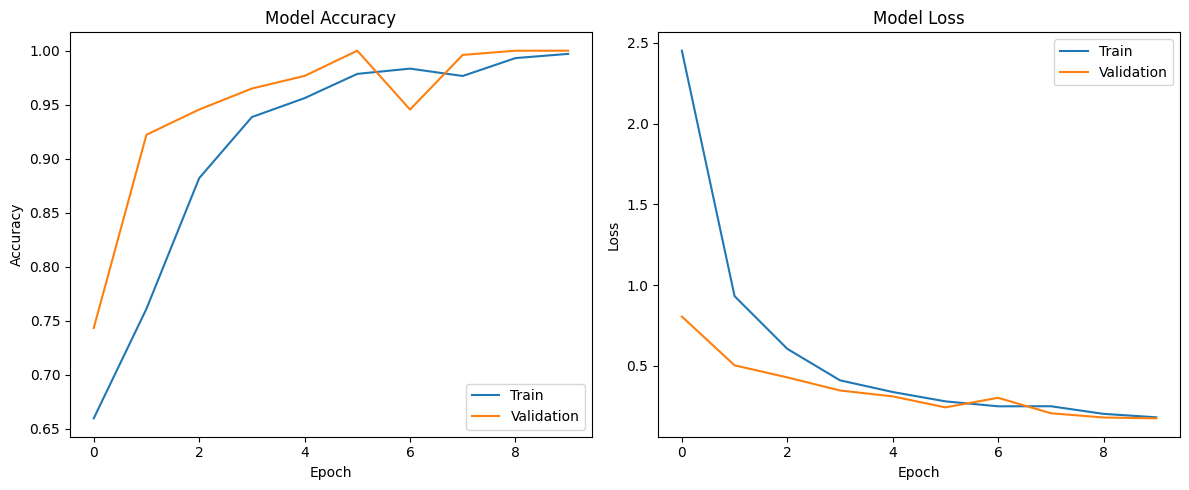

Training and evaluation completed.


In [21]:
 # Train and evaluate the model
print("Training the model...")
model = train_and_evaluate(X_train, X_test, y_train, y_test)
    
print("Training and evaluation completed.")


In [22]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 58,562,629 (223.40 MB)

 Trainable params: 12,846,081 (49.00 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

 Optimizer params: 25,692,164 (98.01 MB)